# Linearity of the mass balance model
In this notebook I look at the mass balance model and asses wheter or not it behave linearly as a function of temperature bias.

In [5]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import the needed OGGM modules
import oggm
from oggm import cfg, utils, graphics, workflow
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, inversion, flowline, massbalance
import oggm_vas as vascaling

In [6]:
# specify and create directory for plots
plot_dir = '/Users/oberrauch/work/master/plots/linearity'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [7]:
# specify the RGI ID for Hintereisferner
rgi_id = 'RGI60-11.00897'
rgi_region = (rgi_id.split('-')[-1]).split('.')[0]
rgi_version = (rgi_id.split('-')[0])[-2:]

## Preprocessing

In [8]:
# load default parameter file
vascaling.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 10
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 2.5
cfg.PARAMS['temp_melt'] = -0.5

2020-11-17 11:01:25: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-11-17 11:01:25: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-11-17 11:01:25: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-11-17 11:01:25: oggm.utils: Checking the download verification file checksum...
2020-11-17 11:01:26: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `60`.
2020-11-17 11:01:26: oggm.cfg: PARAMS['border'] changed from `20` to `10`.
2020-11-17 11:01:26: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-11-17 11:01:26: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-0.5`.


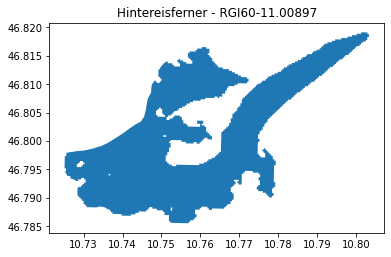

In [9]:
# read RGI entry for Hintereisferner as DataFrame
# containing the outline area as shapefile
entity = utils.get_rgi_glacier_entities([rgi_id])
# quick look, to make sure we got the rigth one
entity.plot()
plt.title('Hintereisferner - ' + rgi_id)
# select the row containing HEF from DataFrame
entity = entity.iloc[0]

In [10]:
# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

In [11]:
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, reset=True)

In [12]:
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

2020-11-17 11:01:38: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2020-11-17 11:01:39: oggm.core.gis: (RGI60-11.00897) glacier_masks
2020-11-17 11:01:39: oggm.core.gis: (RGI60-11.00897) process_dem


In [13]:
# process the given climate file
climate.process_climate_data(gdir)

2020-11-17 11:01:39: oggm.core.climate: (RGI60-11.00897) process_climate_data
2020-11-17 11:01:39: oggm.shop.histalp: (RGI60-11.00897) process_histalp_data
2020-11-17 11:01:40: oggm.utils: /Users/oberrauch/OGGM/download_cache/www.zamg.ac.at/histalp/download/grid5m/HISTALP_temperature_1780-2014.nc.bz2 verified successfully.
2020-11-17 11:01:40: oggm.utils: /Users/oberrauch/OGGM/download_cache/www.zamg.ac.at/histalp/download/grid5m/HISTALP_precipitation_all_abs_1801-2014.nc.bz2 verified successfully.


## Mass balance model

Instance the past mass balance model with the OGGM t*

In [19]:
# compute local temperature sensitivity, using t*=1927
tstar = 1927
vascaling.local_t_star(gdir, tstar=tstar, bias=0)
# instance past mass balance model
past_mb_mod = vascaling.VAScalingMassBalance(gdir)

2020-11-17 11:03:55: oggm_vas.core: (RGI60-11.00897) local_t_star


In [15]:
# get equilibrium year t*
tstar = gdir.read_json('vascaling_mustar')['t_star']
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# create empty container
past_mb = list()
years = np.arange(tstar - cfg.PARAMS['mu_star_halfperiod'],
                  tstar + cfg.PARAMS['mu_star_halfperiod'] + 1)

for yr in years:
    mb_yr = past_mb_mod.get_specific_mb(min_hgt, max_hgt, yr)
    past_mb.append(mb_yr)
    
# convert into pd.DataFrame
past_mb = pd.DataFrame(past_mb, index = years.astype(int), columns=['spec_mb'])

Text(0, 0.5, 'Spec. mb [mm we./yr]')

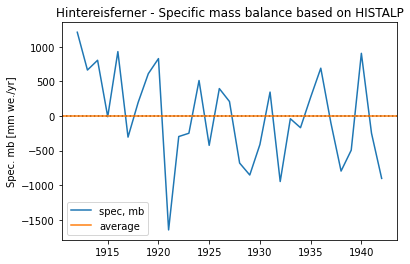

In [18]:
plt.plot(past_mb, label='spec, mb')
plt.axhline(0, c='k', ls=':')
plt.axhline(np.average(past_mb), label='average', c='C1')
plt.legend()
plt.title('Hintereisferner - Specific mass balance based on HISTALP')
plt.ylabel('Spec. mb [mm we./yr]')

Compare mass balance parameters between the VAS an OGGM t* 

In [23]:
# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)
gdir.read_json('vascaling_mustar')

2020-11-17 11:06:17: oggm_vas.core: (RGI60-11.00897) local_t_star


{'rgi_id': 'RGI60-11.00897',
 't_star': 1885,
 'bias': -6.4709963211017785,
 'mu_star': 80.99722152736051}

In [24]:
# use t* = 1927, coherent with eq runs
tstar = 1927
vascaling.local_t_star(gdir, tstar=tstar, bias=0)
gdir.read_json('vascaling_mustar')

2020-11-17 11:06:17: oggm_vas.core: (RGI60-11.00897) local_t_star


{'rgi_id': 'RGI60-11.00897',
 't_star': 1927,
 'bias': 0,
 'mu_star': 82.80283386944309}

Instance the constant mass balance model

In [26]:
# instance the mass balance models
temp_bias = 1
eq_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
pos_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
pos_mb_mod.temp_bias = -temp_bias
neg_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
neg_mb_mod.temp_bias = +temp_bias

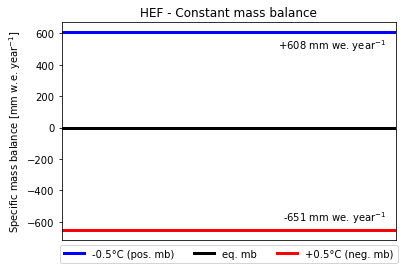

In [28]:
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
# compute mass balance
pos_mb = pos_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0)
eq_mb = eq_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0)
neg_mb = neg_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0)
# visualize
#fig, ax = plt.subplots(1,1, figsize=[6,4])
plt.axhline(pos_mb, c='b', label='-0.5°C (pos. mb)', lw=3)
plt.axhline(eq_mb, c='k', label='eq. mb', lw=3)
plt.axhline(neg_mb, c='r', label='+0.5°C (neg. mb)', lw=3)
plt.legend(ncol=3, bbox_to_anchor=(0.5, 0), loc='upper center')
plt.title('HEF - Constant mass balance')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xticks([]);
# add exact numbers as text/annotation
plt.text(0.97, pos_mb*0.95, '{:+.0f} mm we. year$^{{-1}}$'.format(pos_mb), ha='right', va='top')
plt.text(0.97, neg_mb*0.95, '{:+.0f} mm we. year$^{{-1}}$'.format(neg_mb), ha='right', va='bottom')
# save plot to file
plt.savefig(os.path.join(plot_dir, 'constant_mb.pdf'), bbox_inches='tight')

Compute specific mass balance as function of temperature bias

In [29]:
# define range of temp biases
temp_bias = np.arange(-50, 50.1, 0.1)
# create empty container
const_mb_vas = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb_vas.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb_vas = pd.DataFrame(const_mb_vas, index=temp_bias, columns=['spec_mb'])

Compute linear approximation near 0°C temperature bias...

In [35]:
from sklearn import linear_model

x = const_mb_vas.loc[(temp_bias >= 20)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9999999999801883
intercept: [664.23780242]
slope: [[-993.63528667]]


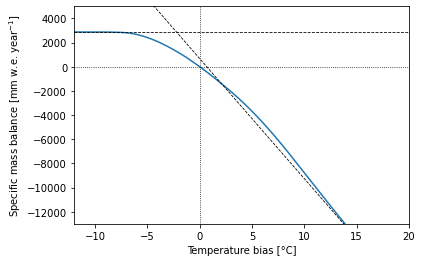

In [36]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

ax.plot(const_mb_vas)
# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Temperature bias [°C]')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xlim([-12,20])
plt.ylim([-1.3e4,0.5e4])

# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax.plot(x, y, ls='--', c='k', lw=0.8)
ax.plot(x[x >= 20],
         y[x >= 20],
         ls='-', c='C1', lw=2, label='linear approx')
y = const_mb_vas.iloc[:20].mean()[0]
ax.axhline(y, ls='--', c='k', lw=0.8)


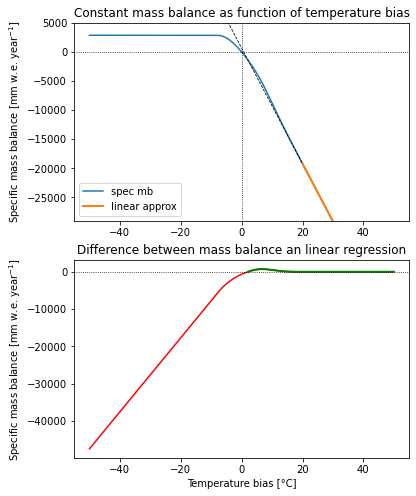

In [38]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb_vas, label='spec mb')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[x >= 20],
         y[x >= 20],
         ls='-', c='C1', lw=2, label='linear approx')
ax0.set_ylim([-29000, 5000])

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb_vas.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

fig.savefig(os.path.join(plot_dir, 'lin_reg_slope.pdf'), bbox_inches='tight')

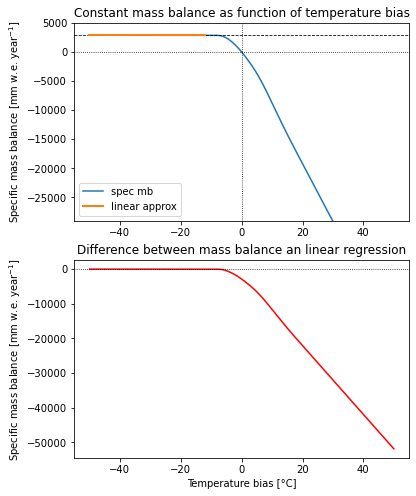

In [42]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb_vas, label='spec mb')
# plot linear regression
x = temp_bias
y = const_mb_vas.iloc[:20].mean()[0]
ax0.axhline(y, ls='--', c='k', lw=0.8)
ax0.plot([-50, -12], [y, y],
         ls='-', c='C1', lw=2, label='linear approx')
ax0.set_ylim([-29000, 5000])

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb_vas.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

fig.savefig(os.path.join(plot_dir, 'lin_reg_const.pdf'), bbox_inches='tight')

In [43]:
# define range of temp biases
bias_limit = 5
temp_bias = np.arange(-bias_limit, bias_limit+0.1, 0.1)
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=temp_bias, columns=['spec_mb'])

In [49]:
bias_limit = 1
x = const_mb.loc[(temp_bias >= -(bias_limit+0.01)) & (temp_bias <= bias_limit)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.999649311448397
intercept: [-7.97561831]
slope: [[-628.97432308]]


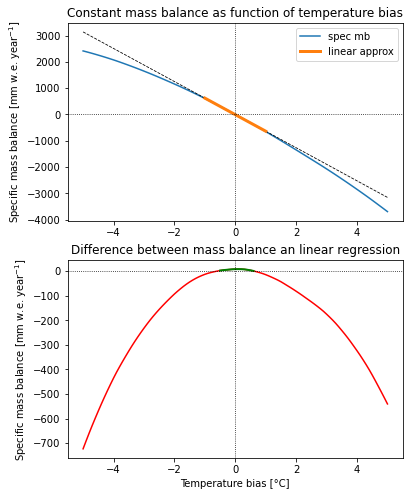

In [51]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb, label='spec mb')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         y[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         ls='-', c='C1', lw=3, label='linear approx')

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.axvline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

fig.savefig(os.path.join(plot_dir, 'lin_reg_detail.pdf'), bbox_inches='tight')

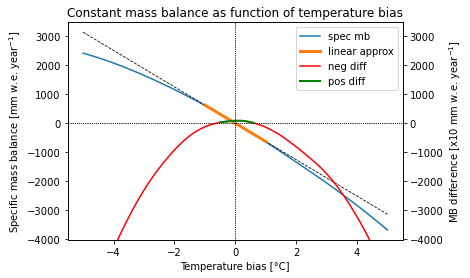

In [52]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1)

# plot mass balance
ax0.plot(const_mb, label='spec mb')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         y[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         ls='-', c='C1', lw=3, label='linear approx')

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')

# get secondary y axisx
ax1 = ax0.twinx()

# compute and plot differences in spec mb
dif = (const_mb.values.flatten() - y) * 10
ax1.plot(x, dif, c='r', label='neg diff')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2, label='pos diff')
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.axvline(0, c='k', ls=':', lw=0.8)
ax0.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('MB difference [x10 mm w.e. year$^{-1}$]')
ax1.set_ylim(ax0.get_ylim())

h = np.array([h for h, l in [ax0.get_legend_handles_labels(), ax1.get_legend_handles_labels()]]).flatten()
l = np.array([l for h, l in [ax0.get_legend_handles_labels(), ax1.get_legend_handles_labels()]]).flatten()
ax1.legend(h, l)

fig.savefig(os.path.join(plot_dir, 'lin_reg_detail_oneplot.pdf'), bbox_inches='tight')

The constant mass balance can be approximate by a linear function for temperature biases between -1°C and 1°C, with a coefficient of determination of 0.9995.

Take a quick look at the precipiation bias...

In [53]:
# define range of temp biases
prcp_bias = np.unique(np.sort(np.concatenate([1/np.arange(1,10+1), np.arange(1,10+1)])))
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in prcp_bias:
    # add temperature bias
    const_mb_mod.prcp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=prcp_bias, columns=['spec_mb'])

In [54]:
bias_limit = None
x = const_mb
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9999999999999999
intercept: [-2029.5374727]
slope: [[2029.53746818]]


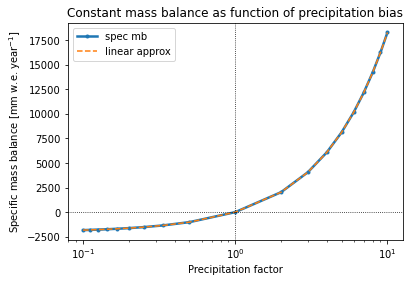

In [57]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

#
ax.semilogx(const_mb, marker='.', lw=2.5, label='spec mb')
ax.plot(prcp_bias, lin_mod.coef_[0] * prcp_bias + lin_mod.intercept_, label='linear approx', ls='--')

# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(1, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Precipitation factor')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax.set_title('Constant mass balance as function of precipitation bias')
ax.legend()

fig.savefig(os.path.join(plot_dir, 'lin_reg_prcp.pdf'), bbox_inches='tight')


### Output from `compare_mb.py`

In [58]:
# define path and filenames
dir_path = '/Users/oberrauch/work/master/data/tmp/'
f_name = 'mb_output.nc'
path = os.path.join(dir_path, f_name.format(m))
ds = xr.load_dataset(path)

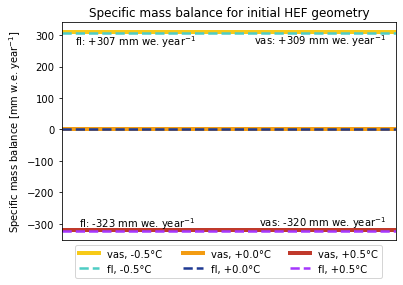

In [64]:

# define color cycles
vas_cycle = np.array(['#f7ca18', '#f39c12', '#c0392b', '#22313f', '#4d13d1', '#59abe3'])
fl_cycle = np.array(["#4ecdc4", "#1f3a93", "#a537fd", "#26a65b", "#00e640", "#0093ac"])
colors = [vas_cycle, fl_cycle]


for i, b in enumerate([-0.5, 0, +0.5]):
    for m, c, ls, lw in zip(models, colors, ['-', '--'], [4, 2.5]):
        mb = ds.sel(rgi_id='RGI60-11.00897', year=0, temp_bias=b, model=m).spec_mb
        plt.axhline(mb, c=c[i], label='{}, {:+.1f}°C'.format(m, b), lw=lw, ls=ls)
        if b:
            # add exact numbers as text/annotation
            x = 0.97 if m=='vas' else 0.4
            plt.text(x, mb, '{}: {:+.0f} mm we. year$^{{-1}}$'.format(m, float(mb)),
                     ha='right', va='top' if b < 0 else 'bottom')

plt.legend(ncol=3, bbox_to_anchor=(0.5, 0), loc='upper center')
plt.title('Specific mass balance for initial HEF geometry')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xticks([]);



### Flowline model

In [74]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 10
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

# initialize the GlacierDirectory
rgidf = utils.get_rgi_glacier_entities([rgi_id])
gdir = workflow.init_glacier_directories(rgidf, reset=False, force=True)[0]

# run gis tasks
workflow.gis_prepro_tasks(gdir)
# run climate tasks
workflow.execute_entity_task(climate.process_climate_data, gdir)
# compute local t* and the corresponding mu*
# compute mustar from the reference table for the flowline model
# RGI v6 and HISTALP baseline climate
tstar = 1927
climate.local_t_star(gdir, tstar=tstar, bias=0)

workflow.execute_entity_task(climate.mu_star_calibration, [gdir])
# run inversion tasks
workflow.inversion_tasks([gdir])
# finalize preprocessing
workflow.execute_entity_task(flowline.init_present_time_glacier, [gdir])

2020-11-17 16:10:30: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-11-17 16:10:30: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-11-17 16:10:30: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-11-17 16:10:30: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `60`.
2020-11-17 16:10:30: oggm.cfg: PARAMS['border'] changed from `20` to `10`.
2020-11-17 16:10:30: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-11-17 16:10:30: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-11-17 16:10:30: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-11-17 16:10:31: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers
2020-11-17 16:10:32: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-11-17 16:10:32: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2020-11-17 16:10:33: oggm.workflow: Execute 

[None]

Compute specific mass balance as function of temperature bias

In [75]:
# define range of temp biases
temp_bias = np.arange(-50, 50.1, 0.1)
# create empty container
const_mb_fl = list()

# read flowline
fls = gdir.read_pickle('model_flowlines')

# instance mass balance model
const_mb_mod = massbalance.ConstantMassBalance(gdir, y0=tstar, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb_fl.append(const_mb_mod.get_specific_mb(fls=fls, year=0))
    
# convert into DataFrame
const_mb_fl = pd.DataFrame(const_mb_fl, index=temp_bias, columns=['spec_mb'])

Plot mass balance functions for both evolution models

Text(0.5, 1.0, 'HEF - Constant specific mass balance as function of temperature bias')

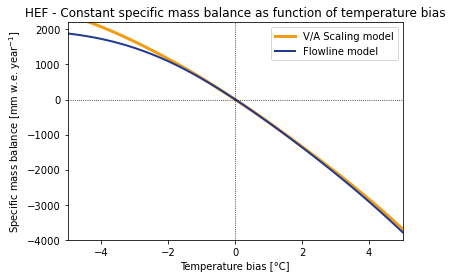

In [76]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

ax.plot(const_mb_vas, label='V/A Scaling model', c=vas_cycle[1], lw=3)
ax.plot(const_mb_fl, label='Flowline model', c=fl_cycle[1], lw=2)

# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Temperature bias [°C]')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xlim([-5,5])
plt.ylim([-4e3,2.2e3])
plt.legend()
plt.title('HEF - Constant specific mass balance as function of temperature bias')

In [77]:
# Compute linear approximation near 0°C temperature bias...

In [78]:
from sklearn import linear_model

bias_limit = 1

x = const_mb_fl.loc[(temp_bias >= -bias_limit) & (temp_bias <= +bias_limit)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod_fl = linear_model.LinearRegression()
lin_mod_fl.fit(x, y)
# get results
r_sq = lin_mod_fl.score(x, y)
print('Flowline model\n-------------------')
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod_fl.intercept_[0])
print('slope:', lin_mod_fl.coef_[0][0])

Flowline model
-------------------
coefficient of determination: 0.9992432404431012
intercept: -10.879220561288452
slope: -625.2534388424419


In [79]:
x = const_mb_vas.loc[(temp_bias >= -bias_limit) & (temp_bias <= +bias_limit)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod_vas = linear_model.LinearRegression()
lin_mod_vas.fit(x, y)
# get results
r_sq = lin_mod_vas.score(x, y)
print('V/A Scaling model\n-----------------')
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod_vas.intercept_[0])
print('slope:', lin_mod_vas.coef_[0][0])

V/A Scaling model
-----------------
coefficient of determination: 0.9996890734443852
intercept: -7.1349417716011665
slope: -626.6815688905482


Text(0.5, 1.0, 'HEF - Constant specific mass balance as function of temperature bias')

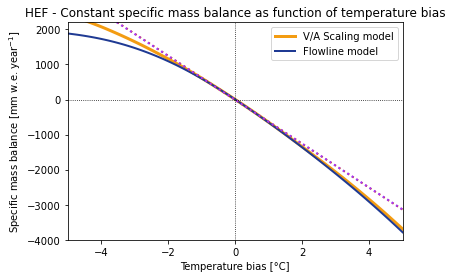

In [80]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

# plot mass balance as function of temperature bias
ax.plot(const_mb_vas, label='V/A Scaling model', c=vas_cycle[1], lw=3)
ax.plot(const_mb_fl, label='Flowline model', c=fl_cycle[1], lw=2)

# plot linear regressions
x = temp_bias
# vas model
y = x * lin_mod_vas.coef_[0][0] + lin_mod_vas.intercept_[0]
plt.plot(x,y, c=vas_cycle[2], lw=2, ls=':')
# flowline model
y = x * lin_mod_fl.coef_[0][0] + lin_mod_fl.intercept_[0]
plt.plot(x,y, c=fl_cycle[2], lw=2, ls=':')

# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Temperature bias [°C]')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xlim([-5,5])
plt.ylim([-4e3,2.2e3])
plt.legend()
plt.title('HEF - Constant specific mass balance as function of temperature bias')